### Import libraries 

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Flatten

### Load the signals

In [5]:
# In this approach raw signals are used instead of the handcoded features

SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"    
]


In [6]:
# utility functions to read data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

def load_signals(subset):
    signals_data = []
    for signal in SIGNALS:
        filename = f'HAR/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(_read_csv(filename).to_numpy())
    return np.transpose(signals_data,(1,2,0))

In [7]:
def load_y(subset):
    """One hot encoding of the labels 0,1,2,3,4,5,6 classes"""
    
    fname = f'HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(fname)[0]
    return pd.get_dummies(y).to_numpy()

In [8]:
def load_data():
    """ function to obtain """
    
    X_train, X_test = load_signals('train'),load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')
    
    return X_train, X_test, y_train, y_test

In [9]:
X_train, X_test, Y_train, Y_test = load_data()

In [64]:
#Utility function to plot confusion matrix

import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize = False, title="Confusion Matrix", cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
        
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0
        
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i , format(cm[i,j], fmt),
                horizontalalignment = 'center', color='white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

### Split the data into Dynamic and Static activities 

In [11]:
def test_split(subset):
    """The method splits the test data into dynamic and static activities and returns one hot encoded values of test"""
    fname = f'HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(fname)[0]
    y[y<=3] = 0 #Dynamic activities WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    y[y>3] = 1  #Static activities STANDING, SITTING, LAYING
    return pd.get_dummies(y).to_numpy()

In [12]:
y_train_split, y_test_split = test_split('train'), test_split('test')

In [13]:
print(y_train_split.shape)
print(y_test_split.shape)

(7352, 2)
(2947, 2)


### Model1 - classifying data into Static and Dynamic Activities

In [14]:
model = Sequential()
model.add(Conv1D(filters = 64, kernel_size=3, activation='relu',kernel_initializer='he_uniform', input_shape=(128,9)))
model.add(Conv1D(filters = 64, kernel_size=3, activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.4))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
model.fit(X_train, y_train_split, epochs=30, batch_size=16, validation_data=(X_test, y_test_split))

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 5s 653us/step - loss: 0.0235 - accuracy: 0.9915 - val_loss: 0.0153 - val_accuracy: 0.9964
Epoch 2/30
7352/7352 [==============================] - 2s 300us/step - loss: 0.0027 - accuracy: 0.9990 - val_loss: 0.1328 - val_accuracy: 0.9664
Epoch 3/30
7352/7352 [==============================] - 2s 310us/step - loss: 0.0025 - accuracy: 0.9994 - val_loss: 0.0094 - val_accuracy: 0.9976
Epoch 4/30
7352/7352 [==============================] - 2s 312us/step - loss: 0.0035 - accuracy: 0.9986 - val_loss: 0.1729 - val_accuracy: 0.9603
Epoch 5/30
7352/7352 [==============================] - 2s 321us/step - loss: 9.3753e-04 - accuracy: 0.9998 - val_loss: 0.0176 - val_accuracy: 0.9968
Epoch 6/30
7352/7352 [==============================] - 2s 312us/step - loss: 6.8007e-05 - accuracy: 1.0000 - val_loss: 0.0214 - val_accuracy: 0.9969
Epoch 7/30
7352/7352 [==============================] - 2s 312us/ste

In [16]:
#saving the model for future use
model.save('HAR_Proj/model/binary_model.h5')

> __Note:__ The above model has 99.86% accuracy on test data

### Model2 - Classifying Static activities

In [17]:
def load_static_data(subset):
    """This method returns 
        a. one hot encoded labels of static actvities 
        b. pandas series containing static activities"""
    fname = f'HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(fname)[0]
    y_df = y > 3
    y=y[y_df]
    return pd.get_dummies(y).to_numpy(),y_df

In [19]:
y_train_static, X_train_df = load_static_data('train')
y_test_static, X_test_df = load_static_data('test')

In [21]:
X_train_static = X_train[X_train_df]
X_test_static = X_test[X_test_df]

In [23]:
print(X_train_static.shape)
print(y_train_static.shape)
print(X_test_static.shape)
print(y_test_static.shape)


(4067, 128, 9)
(4067, 3)
(1560, 128, 9)
(1560, 3)


In [24]:
model_static = Sequential()
model_static.add(Conv1D(filters=64, kernel_size=5, padding='same', activation='relu',kernel_initializer='he_uniform', input_shape = (128,9)))
model_static.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu',kernel_initializer='he_uniform'))
model_static.add(Dropout(0.2))
model_static.add(MaxPooling1D(pool_size=2))
model_static.add(Flatten())
model_static.add(Dense(64, activation='relu',kernel_initializer='he_uniform'))
model_static.add(BatchNormalization())
model_static.add(Dropout(0.4))

model_static.add(Dense(3, activation='softmax'))

In [29]:
model_static.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
model_static.fit(X_train_static,y_train_static, epochs=30, batch_size=16,validation_data=(X_test_static, y_test_static))

Train on 4067 samples, validate on 1560 samples
Epoch 1/30
4067/4067 [==============================] - 4s 881us/step - loss: 0.2829 - accuracy: 0.8866 - val_loss: 0.3625 - val_accuracy: 0.8673
Epoch 2/30
4067/4067 [==============================] - 2s 484us/step - loss: 0.2519 - accuracy: 0.8982 - val_loss: 0.3810 - val_accuracy: 0.8468
Epoch 3/30
4067/4067 [==============================] - 2s 494us/step - loss: 0.2284 - accuracy: 0.9103 - val_loss: 0.3993 - val_accuracy: 0.8603
Epoch 4/30
4067/4067 [==============================] - 2s 491us/step - loss: 0.2221 - accuracy: 0.9083 - val_loss: 0.3104 - val_accuracy: 0.8814
Epoch 5/30
4067/4067 [==============================] - 2s 468us/step - loss: 0.2145 - accuracy: 0.9095 - val_loss: 0.3260 - val_accuracy: 0.8853
Epoch 6/30
4067/4067 [==============================] - 2s 491us/step - loss: 0.2199 - accuracy: 0.9061 - val_loss: 0.3647 - val_accuracy: 0.8545
Epoch 7/30
4067/4067 [==============================] - 2s 506us/step - loss

In [65]:
STATIC_ACTIVITIES = {
    0:'SITTING',
    1:'STANDING',
    2:'LAYING'
}

y_pred = model_static.predict(X_test_static)

In [66]:
#utility function to create confusion matrix
def confusion_matrix_table(y_true, y_pred, activities):
    y_true = pd.Series([activities[y] for y in np.argmax(y_true, axis = 1)])
    y_pred = pd.Series([activities[y] for y in np.argmax(y_pred, axis = 1)])
    
    return confusion_matrix(y_true, y_pred)

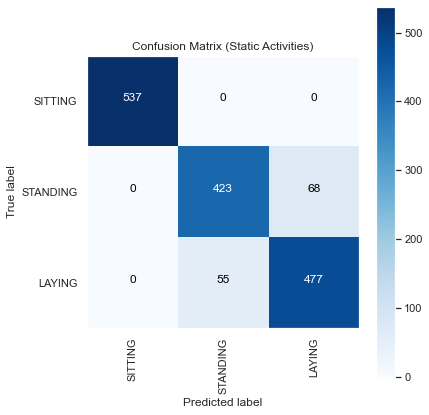

In [68]:
#plotting confusion matrix
plt.figure(figsize=(6,6))
plt.grid(b=False)
cm = confusion_matrix_table(y_test_static, y_pred,activities = STATIC_ACTIVITIES)
plot_confusion_matrix(cm, classes=['SITTING','STANDING','LAYING'],title='Confusion Matrix (Static Activities)')
plt.show()

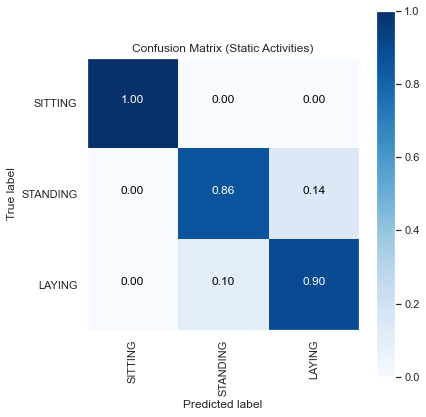

In [69]:
#plotting confusion matrix(normalized)
plt.figure(figsize=(6,6))
plt.grid(b=False)
cm = confusion_matrix_table(y_test_static, y_pred,activities = STATIC_ACTIVITIES)
plot_confusion_matrix(cm, classes=['SITTING','STANDING','LAYING'],title='Confusion Matrix (Static Activities)',normalize=True)
plt.show()

In [96]:
model.save('HAR_Proj/model/static_model.h5')

### Model3 - Classyifying Dynamic Activities

In [87]:
def load_dynamic_data(subset):
    """This method returns 
        a. one hot encoded labels of static actvities 
        b. pandas series containing static activities"""
    fname = f'HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(fname)[0]
    y_df = y <= 3
    y=y[y_df]
    return pd.get_dummies(y).to_numpy(),y_df

In [88]:
y_train_dynamic, X_train_df = load_dynamic_data('train')
y_test_dynamic, X_test_df = load_dynamic_data('test')

In [89]:
X_train_dynamic = X_train[X_train_df]
X_test_dynamic = X_test[X_test_df]

In [91]:
print(X_train_dynamic.shape)
print(y_train_dynamic.shape)
print(X_test_dynamic.shape)
print(y_test_dynamic.shape)


(3285, 128, 9)
(3285, 3)
(1387, 128, 9)
(1387, 3)


In [92]:
model_dynamic = Sequential()
model_dynamic.add(Conv1D(filters=64, kernel_size=5, padding='same',activation='relu',kernel_initializer='he_uniform',input_shape=(128,9)))
model_dynamic.add(Conv1D(filters=64,kernel_size=3,padding='same',activation='relu',kernel_initializer='he_uniform'))
model_dynamic.add(Dropout(0.4))
model_dynamic.add(MaxPooling1D(pool_size=2))
model_dynamic.add(Flatten())
model_dynamic.add(Dense(64,activation='relu',kernel_initializer='he_uniform'))
model_dynamic.add(BatchNormalization())
model_dynamic.add(Dropout(0.2))
model_dynamic.add(Dense(64))
model_dynamic.add(BatchNormalization())
model_dynamic.add(Dropout(0.2))
model_dynamic.add(Dense(3,activation='softmax'))


In [93]:
model_dynamic.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_dynamic.fit(X_train_dynamic,y_train_dynamic,epochs = 30, batch_size=16,validation_data=(X_test_dynamic,y_test_dynamic))

Train on 3285 samples, validate on 1387 samples
Epoch 1/30
3285/3285 [==============================] - 5s 2ms/step - loss: 0.5159 - accuracy: 0.7954 - val_loss: 0.4153 - val_accuracy: 0.8104
Epoch 2/30
3285/3285 [==============================] - 3s 1ms/step - loss: 0.0777 - accuracy: 0.9732 - val_loss: 0.1385 - val_accuracy: 0.9611
Epoch 3/30
3285/3285 [==============================] - 3s 1ms/step - loss: 0.0727 - accuracy: 0.9775 - val_loss: 0.1591 - val_accuracy: 0.9531
Epoch 4/30
3285/3285 [==============================] - 3s 1ms/step - loss: 0.0261 - accuracy: 0.9915 - val_loss: 0.1792 - val_accuracy: 0.9539
Epoch 5/30
3285/3285 [==============================] - 3s 1ms/step - loss: 0.0152 - accuracy: 0.9960 - val_loss: 0.0983 - val_accuracy: 0.9704
Epoch 6/30
3285/3285 [==============================] - 3s 1ms/step - loss: 0.0186 - accuracy: 0.9945 - val_loss: 0.1140 - val_accuracy: 0.9640
Epoch 7/30
3285/3285 [==============================] - 3s 1ms/step - loss: 0.0235 - acc

In [94]:
DYNAMIC_ACTIVITIES = {
    0:'WALKING',
    1:'WALKING_UPSTAIRS',
    2:'WALKING_DOWNSTAIRS'
}

y_pred = model_dynamic.predict(X_test_dynamic)

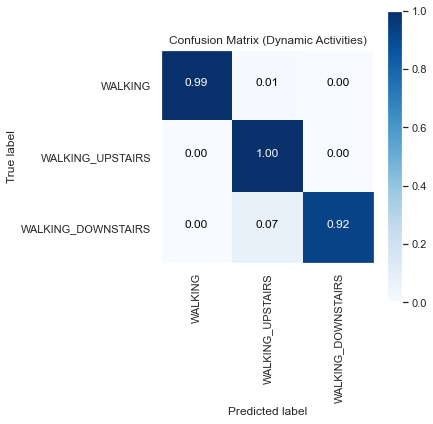

In [95]:
#plotting confusion matrix(normalized)
plt.figure(figsize=(6,6))
plt.grid(b=False)
cm = confusion_matrix_table(y_test_dynamic, y_pred,activities = DYNAMIC_ACTIVITIES)
plot_confusion_matrix(cm, classes=['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS'],title='Confusion Matrix (Dynamic Activities)',normalize=True)
plt.show()

In [97]:
model.save('HAR_Proj/model/dynamic_model.h5')

### Prediction Pipeline

In [132]:
pred_binary = model.predict(X_test)
y_predict_binary = np.argmax(pred_binary, axis = 1)

X_static = X_test[y_predict_binary == 1]
X_dynamic = X_test[y_predict_binary == 0]

In [133]:
#classifying among static activities
static_predict = model_static.predict(X_static)
static_predict = np.argmax(static_predict, axis =1)
static_predict = static_predict + 4

In [134]:
#classifying among dynamic activities
dynamic_predict = model_dynamic.predict(X_dynamic)
dynamic_predict = np.argmax(dynamic_predict, axis =1)
dynamic_predict = dynamic_predict + 1

In [135]:
final_prediction = []
i,j = 0,0


for idx in y_predict_binary:
    if idx == 1:
        final_prediction.append(static_predict[i])
        i+=1
    else:
        final_prediction.append(dynamic_predict[j])
        j+=1

In [143]:
fname = f'HAR/UCI_HAR_Dataset/test/y_test.txt'
ytest = _read_csv(fname)[0]

print("Accuracy on the test data from the final model = ", accuracy_score(ytest, final_prediction))

Accuracy on the test data from the final model =  0.9440108585001696


> Thus the divide and conquer approach has performed substantially better than the 2 LSTM model.

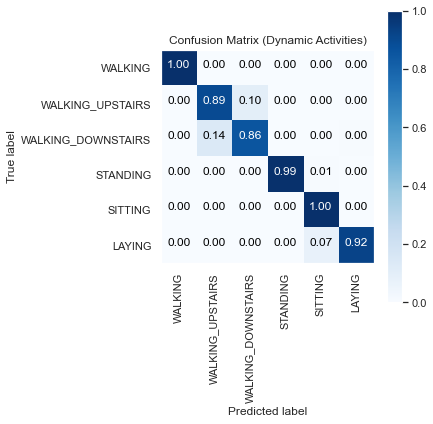

In [142]:
ACTIVITIES = {
    0:'WALKING',
    1:'WALKING_UPSTAIRS',
    2:'WALKING_DOWNSTAIRS',
    3:'STANDING',
    4:'SITTING',
    5:'LAYING'
}

#plotting confusion matrix(normalized)
plt.figure(figsize=(6,6))
plt.grid(b=False)
cm = confusion_matrix_table(Y_test, pd.get_dummies(final_prediction).to_numpy(),activities = ACTIVITIES)
plot_confusion_matrix(cm, classes=['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','STANDING','SITTING','LAYING'],title='Confusion Matrix (Dynamic Activities)',normalize=True)
plt.show()